# COMPS II
### A notebook for producing paper-quality figures and captions for my upcoming COMPS-II paper.
##### Initialized by Drew Camron Sep 2018

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np

from pyresample import geometry, image

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='poster')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36359 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
indir_rcp = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_1850 = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_obs = '/glade/work/mcamron/obs/cloudsat/tristan/'
indir_mask = '/glade/work/mcamron/gismask_RACMO23_0.9x1.25_con.nc'
indir_topo = '/glade/work/mcamron/USGS-gtopo30_0.9x1.25_remap_c051027.nc'

In [4]:
ds_vars = ['RADAR_LGTRAIN', 'RADAR_LGTRAINO', 'RADAR_RAIN', 'RADAR_RAINO', 'RADAR_LGTSNOW', 'RADAR_LGTSNOWO', 'RADAR_SNOW', 'RADAR_SNOWO']

fn_tseries_rcp = 'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fn_tseries_1850 = 'b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fext_tseries_rcp = '.200601-209512.nc'
fext_tseries_1850 = '.000101-010012.nc'

fnames_rcp = [indir_rcp + fn_tseries_rcp + var + fext_tseries_rcp for var in ds_vars]
fnames_1850 = [indir_1850 + fn_tseries_1850 + var + fext_tseries_1850 for var in ds_vars]

obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [indir_obs+file for file in os.listdir(indir_obs) if mo+yr in file]
        
ds_rcp = xr.open_mfdataset(fnames_rcp, decode_times=False).sel(lat=slice(0, 90))
ds_1850 = xr.open_mfdataset(fnames_1850, decode_times=False).sel(lat=slice(0, 90))
ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ds_rcp['time'] = pd.date_range('2006-01', '2095-12', freq='MS')
ds_1850['time'] = pd.date_range('2006-01', '2105-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))

msi = xr.open_dataarray(indir_mask).sel(lat=slice(0, 90))
ms = msi.where(msi > 0)

ds_topo = xr.open_dataset(indir_topo).sel(lat=slice(0, 90))

In [5]:
ds_pres = ds_rcp.isel(time=slice(0, 180))
ds_fut = ds_rcp.isel(time=slice(-181, -1))

rain_pres = (
    ds_pres['RADAR_RAIN'] + ds_pres['RADAR_LGTRAIN'])
snow_pres = (
    ds_pres['RADAR_SNOW'] + ds_pres['RADAR_LGTSNOW'])

rain_fut = (
    ds_fut['RADAR_RAIN'] + ds_fut['RADAR_LGTRAIN'])
snow_fut = (
    ds_fut['RADAR_SNOW'] + ds_fut['RADAR_LGTSNOW'])

rain_obs = (
    (ds_obs['raincounts'] + #ds_obs['heavyraincounts'] +    # heavy rain is a subset of rain certain
     ds_obs['probablecounts'] + ds_obs['possiblecounts']) / ds_obs['counts'])
snow_obs = (
    (ds_obs['snowcounts'] + ds_obs['snowpossiblecounts']) / ds_obs['counts'])

---
## Figure 1
`CLOUDSAT` sum rain frequency and sum snow frequency maps, shown annually and seasonally.

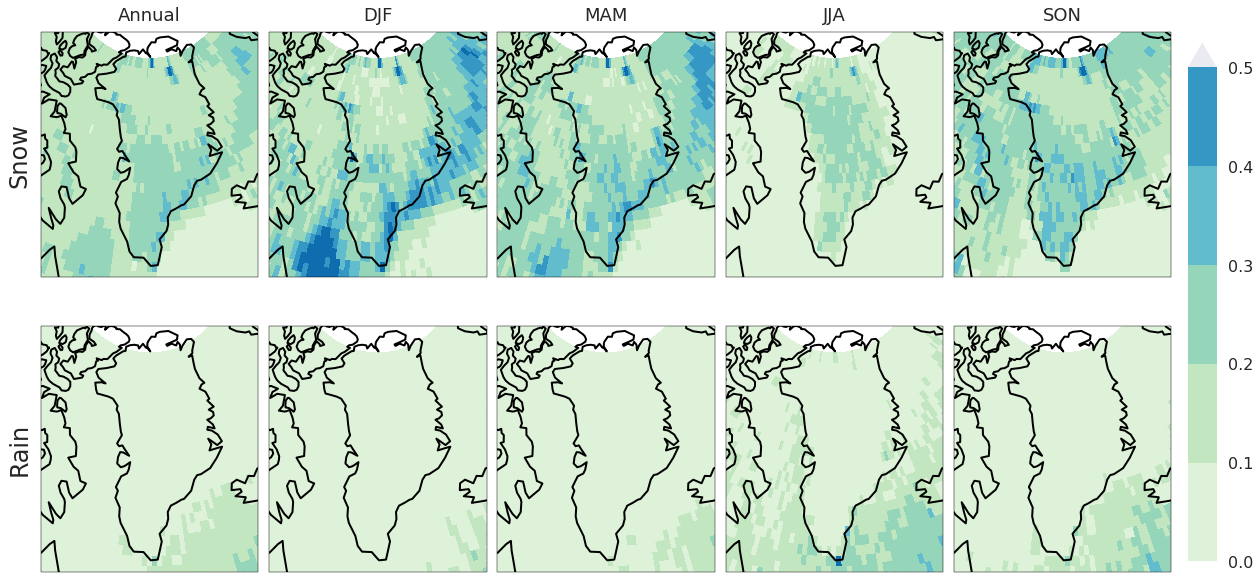

In [6]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']
vm = 0.5

vmlv = int(vm*10 + 1)
levels = list(np.linspace(0, vm, vmlv))
colors = sns.color_palette('GnBu', vmlv)

(snow_obs
 .mean('time')
 .plot.pcolormesh(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    (snow_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

p = (rain_obs
    .mean('time')
    .plot.pcolormesh(
        ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

for i, x in enumerate(seasons):
    (rain_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

    
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.1, 0.025, 0.8])
cb = f.colorbar(p, cax=cb_ax, extend='max')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=24, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=24,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Figure1_mapgrid-cloudsat.png',
         bbox_extra_artists=(axes[:, 0]), bbox_inches='tight')

---
## Figure 2
Greenland mean seasonal cycle separated by variable.

In [8]:
w_in = np.tile((ds_rcp['gw']), [len(ds_rcp['lon']), 1]).T
w = w_in / w_in.sum() / 2

mask = np.concatenate((msi.values[:, int(len(msi['lon']) / 2):], msi.values[:, 0:int(len(msi['lon']) / 2)]), axis=1)

x, y = np.meshgrid((msi['lon'].values - 180), msi['lat'])
xx, yy = np.meshgrid(ds_obs['longitude'], ds_obs['latitude']) 

msi_grid = geometry.GridDefinition(lons=x, lats=y)
obs_grid = geometry.GridDefinition(lons=xx, lats=yy)

msi_image = image.ImageContainerNearest(image_data=mask, geo_def=msi_grid, radius_of_influence=500000)
obs_ms = msi_image.resample(obs_grid).image_data

w_image = image.ImageContainerNearest(image_data=w, geo_def=msi_grid, radius_of_influence=100000)
obs_w = w_image.resample(obs_grid).image_data

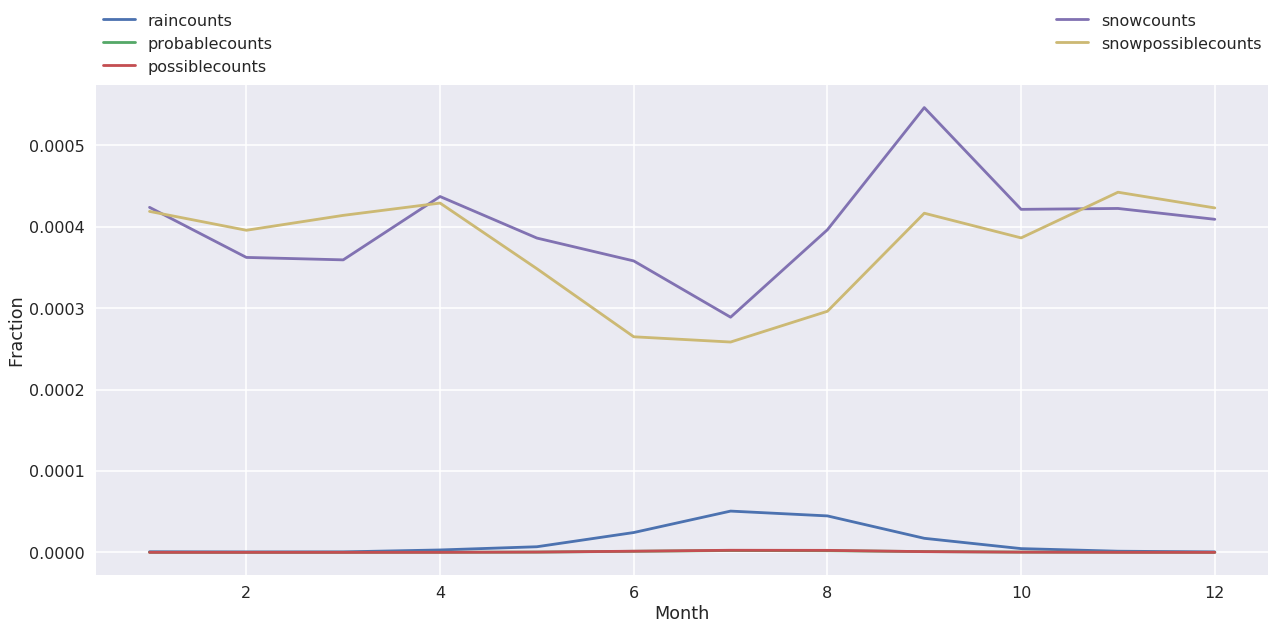

In [9]:
f, ax = plt.subplots(figsize=(21, 9))

obs_vars = ['raincounts', 'probablecounts', 'possiblecounts', 'snowcounts', 'snowpossiblecounts']
for i, var in enumerate(obs_vars):
    ((((ds_obs[var] / ds_obs['counts']) * obs_ms * obs_w).sum('latitude').sum('longitude'))
        .groupby('time.month').mean('time', skipna=True)
         .plot(ax=ax, label=var, color=sns.color_palette('deep', len(obs_vars))[i])#, linewidth=2)
    )
    
ax.autoscale(enable=True)    

ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('Month')
#ax.set_title('Mean seasonal cycle of Greenland-averaged fields', y=1.05, fontsize=28)

f.savefig('../figures/comps2/Figure2_GIS-mean-cycle.png', bbox_inches='tight')

---
## Figure 3
Top: a distribution of precip frequencies by elevation. Bottom: distribution of total area of grids by elevation.

In [11]:
ds_topo

<xarray.Dataset>
Dimensions:       (lat: 95, lon: 288)
Coordinates:
  * lat           (lat) float64 0.4712 1.414 2.356 3.298 4.241 5.183 6.126 ...
  * lon           (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
Data variables:
    PHIS          (lat, lon) float64 ...
    SGH           (lat, lon) float64 ...
    SGH30         (lat, lon) float64 ...
    LANDFRAC      (lat, lon) float64 ...
    LANDM_COSLAT  (lat, lon) float64 ...
Attributes:
    history:    Written on date: 20051027\ndefinesurf -remap -t /fs/cgd/csm/i...
    make_ross:  true
    topofile:   /fs/cgd/csm/inputdata/atm/cam/topo/USGS-gtopo30_10min_c050419.nc
    gridfile:   /fs/cgd/csm/inputdata/atm/cam/coords/fv_0.9x1.25.nc
    landmask:   /fs/cgd/csm/inputdata/atm/cam2/hrtopo/landm_coslat.nc

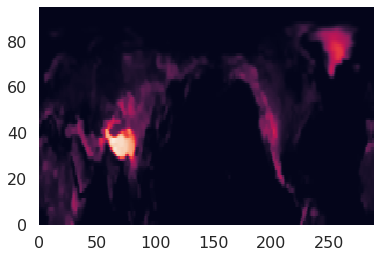

In [12]:
g = 9.80665
topo = (ds_topo['PHIS'] / g)

xxx, yyy = np.meshgrid(topo['lon'], topo['lat'])
topo_grid = geometry.GridDefinition(lons=xxx, lats=yyy)
topo_image = image.ImageContainerNearest(image_data=topo.values, geo_def=topo_grid, radius_of_influence=50000)
obs_topo = topo_image.resample(obs_grid).image_data

plt.pcolormesh(topo_image.image_data)